In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [315]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("..\data\ElectricityMap_DE_2021.csv", sep=",")
#df = df[["datetime","power_production_wind_avg","power_production_solar_avg","timestamp"]]
# shift column 'power_production_wind_avg' to first position
first_column = df.pop("power_production_solar_avg")
df.insert(0, "power_production_solar_avg", first_column)

day = 24*60*60
year = (365.2425)*day

df['sin_hour_of_day'] = np.sin(df["timestamp"] * (2 * np.pi / day))
df['cos_hour_of_day'] = np.cos(df["timestamp"] * (2 * np.pi / day))
df['sin_day_of_year'] = np.sin(df["timestamp"] * (2 * np.pi / year))
df['cos_day_of_year'] = np.cos(df["timestamp"] * (2 * np.pi / year))

#df=df.dropna(axis=1)
y=df.drop(["datetime","timestamp","created_at","updated_at","zone_name","production_sources"],axis=1)
#y=df.drop(["datetime","timestamp"],axis=1)
#y=(y-y.min())/(y.max()-y.min())
y=(y-y.mean())/y.std()
y=y.dropna(axis=1)
y.head()
 


,power_production_solar_avg,carbon_intensity_avg,carbon_intensity_direct_avg,carbon_intensity_production_avg,total_production_avg,total_storage_avg,total_discharge_avg,total_import_avg,total_export_avg,total_consumption_avg,...,latest_forecasted_power_net_import_DK-DK1_avg,latest_forecasted_power_net_import_DK-DK2_avg,latest_forecasted_power_net_import_FR_avg,latest_forecasted_power_net_import_LU_avg,latest_forecasted_power_net_import_NL_avg,latest_forecasted_power_net_import_PL_avg,sin_hour_of_day,cos_hour_of_day,sin_day_of_year,cos_day_of_year
0,-0.650176,0.767006,0.692965,0.769890,-1.647307,-0.732936,-0.647887,0.836618,0.290902,-1.789827,...,1.375512,0.490429,-0.734942,1.213750,-1.478606,-0.311255,-8.536150e-12,1.414133,0.015389,1.415459
1,-0.650176,0.815057,0.740076,0.835387,-1.684726,-0.555183,-0.666773,0.750381,0.496602,-1.960283,...,0.977863,0.954582,-1.186401,1.289913,-1.393684,-0.309705,3.660045e-01,1.365947,0.016403,1.415448
2,-0.650176,0.895364,0.822608,0.915193,-1.709237,1.475695,-0.666773,0.818344,-0.004817,-2.085230,...,0.947059,0.981323,-0.478989,1.302607,-1.436145,-0.311255,7.070664e-01,1.224675,0.017416,1.415436
3,-0.650176,0.899341,0.827021,0.945422,-1.763585,2.154916,-0.666773,0.950739,-0.395155,-2.070439,...,0.840647,0.983233,0.245896,1.289913,-1.379531,-0.311255,9.999429e-01,0.999943,0.018429,1.415423
4,-0.650176,0.988042,0.913132,1.003463,-1.745832,1.484031,-0.666773,0.779513,0.002750,-2.142514,...,0.844380,0.979413,-0.304261,1.239138,-1.642945,-0.311255,1.224675e+00,0.707066,0.019442,1.415410


In [316]:
print(y.shape)

(8760, 62)


In [318]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [319]:
# choose input and output parameters
# x_single = y[["power_production_wind_avg", "sin_hour_of_day",
            #   "sin_day_of_year","cos_hour_of_day",
            #   "cos_day_of_year"]].to_numpy()
x_single = y.to_numpy()
y_single = y[["power_production_solar_avg"]].to_numpy()

# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])
print(testsplit)

# how many "x" inputs to provide in the RNN
past_history = 24*7

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 24

# this can be set to 1. If you have extremely large datasets where values
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used
step = 1

# prepare the data
# inputs here are y and y, since we're only going to predict a single feature (power production wind) at first
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_single, y_train_single = multivariate_data(x_single, y_single, 0, testsplit,
                                                   past_history, future_target, step,
                                                   single_step=False)
x_test_single, y_test_single = multivariate_data(x_single, y_single, testsplit, None,
                                                 past_history, future_target, step,
                                                 single_step=False)

# the network later expects arrays with 3 dimensions, so we have to reshape
# the x_... arrays to reflect that they contain a single feature

x_train_single = x_train_single.reshape(*x_train_single.shape, 1)
x_test_single = x_test_single.reshape(*x_test_single.shape, 1)



7008


In [320]:
print(x_train_single.shape)

(6840, 168, 62, 1)


In [321]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
# clear_session() deletes stale model, so that when this cell is executed again,
# no older model reside in memory
clear_session()

# r2_score defined manually, since it's not implemented in keras
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# below, create a sequential model like before called "single_feature_model"
# 
# then, add an LSTM layer (the class is already imported) with 128 hidden
# vector components. As a second argument you have to provide the
# "input_shape=", that has to be a tuple of the second and third dimension
# of x_train_single, like (20, 30). You can use x_train_single.shape for example to get them
# 
# lastly, add a "Dense" layer like in the lessons before, with as many neurons as
# there are future predictions. That number is saved in the variable "future_target".
# choose an appropriate activation function here. Which ones make sense?
single_feature_model = Sequential()
f=single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[1:3]))
#single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[1:3]))
single_feature_model.add(Dense(future_target, activation='selu'))

# compile the model with the optimizer 'adam', an appropriate loss function, and 
# the "r2_score" defined above as a metric
single_feature_model.compile(optimizer="adam", loss="mse", metrics=r2_score)

# check what the model looks like
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               97792     
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 100,888
Trainable params: 100,888
Non-trainable params: 0
_________________________________________________________________


In [328]:
single_feature_history = single_feature_model.fit(x_train_single, y_train_single, epochs=7, validation_split=0.25)

Epoch 1/7
161/161 [==============================] - 21s 129ms/step - loss: 0.0343 - r2_score: 0.9705 - val_loss: 0.2061 - val_r2_score: 0.6853
Epoch 2/7
161/161 [==============================] - 18s 112ms/step - loss: 0.0244 - r2_score: 0.9790 - val_loss: 0.2092 - val_r2_score: 0.6899
Epoch 3/7
161/161 [==============================] - 20s 124ms/step - loss: 0.0179 - r2_score: 0.9847 - val_loss: 0.2144 - val_r2_score: 0.6854
Epoch 4/7
161/161 [==============================] - 21s 128ms/step - loss: 0.0149 - r2_score: 0.9873 - val_loss: 0.2045 - val_r2_score: 0.6904
Epoch 5/7
161/161 [==============================] - 21s 129ms/step - loss: 0.0127 - r2_score: 0.9892 - val_loss: 0.2023 - val_r2_score: 0.6965
Epoch 6/7
161/161 [==============================] - 19s 116ms/step - loss: 0.0108 - r2_score: 0.9907 - val_loss: 0.2000 - val_r2_score: 0.6993
Epoch 7/7
161/161 [==============================] - 17s 105ms/step - loss: 0.0091 - r2_score: 0.9922 - val_loss: 0.1976 - val_r2_score:

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])


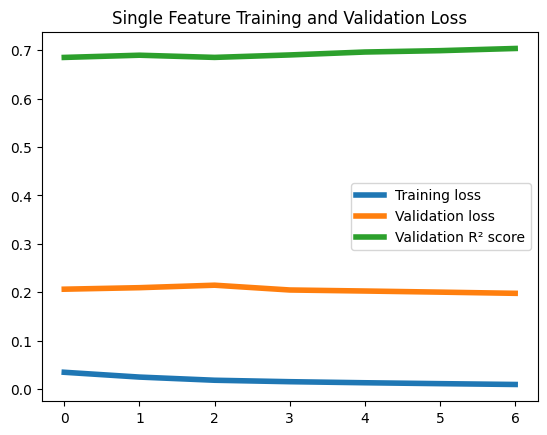

In [329]:
print(single_feature_history.history.keys())

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_r2_score = history.history['val_r2_score']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, lw=4, label='Training loss')
    plt.plot(epochs, val_loss, lw=4, label='Validation loss')
    plt.plot(epochs, val_r2_score, lw=4, label='Validation R² score')
    plt.title(title)
    plt.legend()
    #plt.ylim([0,0.05])

    plt.show()
    
plot_train_history(single_feature_history, 'Single Feature Training and Validation Loss')

In [330]:
y_hat = single_feature_model.predict(x_test_single)

49/49 [==============================] - 2s 46ms/step


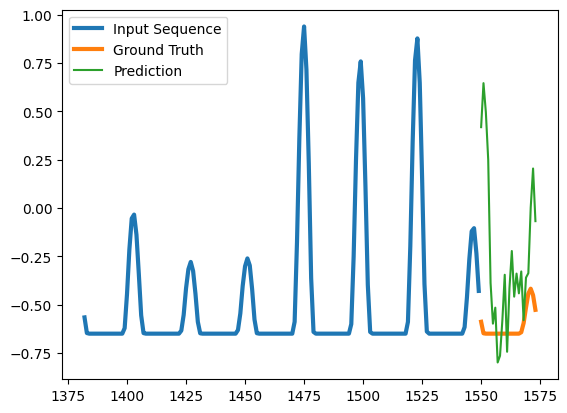

In [339]:
# prediction starting point.
predctStartPt = 1550

t = np.arange(y.shape[0])

predctPt = predctStartPt-past_history
#predctPt = 0

plt.figure()

plt.plot(t[predctPt:past_history+predctPt], x_test_single[predctPt,:,0], lw=3, label="Input Sequence")
plt.plot(t[past_history+predctPt:past_history+predctPt+future_target], y_test_single[predctPt], lw=3, label="Ground Truth")
plt.plot(t[past_history+predctPt:past_history+predctPt+future_target], y_hat[predctPt], label="Prediction")
plt.legend(loc='upper left')
#plt.xlim([850, 980])
#plt.ylim([0,1])

plt.show()

In [352]:
import tensorflow as tf
def gradient_importance(seq, model):
    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)
    with tf.GradientTape() as tape:
        predictions = model(seq)
    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
      
    return grads

grads = gradient_importance(x_train_single[0,:,:,0],single_feature_model)
print(grads.size)

62


In [333]:
import shap

# https://shap.readthedocs.io/en/latest/search.html?q=shap_values&check_keywords=yes&area=default
explainer = shap.explainers.Permutation(single_feature_model,x_train_single)
explainer = shap.Explainer(single_feature_model)
shap_values = explainer(x_test_single)

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 20833!